#### Bibliotecas e Base de Dados

In [294]:
import pandas as pd
import os
import math
from statsmodels.tsa.seasonal import STL
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
# Carregar o dataframe tratado
df = pd.read_csv("base_tratada_lingualab2.csv")


In [295]:
df

,ID_Cliente,Motivo,Education,Cidade,Renda_anual,Aulas,NPS,Num_Aulas,Ano_de_nascimento,Banheiros_na_casa,Quartos_na_casa,motivo_na,renda_na,Quartos_Banheiros,faixa_idade
0,0,Viagem,Graduação,São Paulo,58138.0,Ingles,4,19,1983,3,4,False,False,4Q_3B,1980s
1,1,Trabalho,Graduação,Taubaté,46344.0,Espanhol,4,10,1980,4,3,False,False,3Q_4B,1980s
2,3,Viagem,Graduação,São Paulo,NaN,Espanhol,4,22,2010,1,1,False,True,1Q_1B,2010s
3,4,Trabalho,Doutorado,São Paulo,58293.0,Ingles,3,8,2007,3,4,False,False,4Q_3B,2000s
4,5,Trabalho,Mestrado,São Paulo,NaN,Espanhol,3,9,1993,4,4,False,True,4Q_4B,1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,1484,Viagem,Ensino Médio,São Paulo,75484.0,Ingles,2,44,2002,5,6,False,False,6Q_5B,2000s
2061,1512,Estudos,Graduação,Taubaté,73538.0,Espanhol e Ingles,5,45,1991,5,5,False,False,5Q_5B,1990s
2062,1929,Trabalho,Mestrado,São Paulo,62694.0,Ingles,2,45,1991,3,4,False,False,4Q_3B,1990s
2063,2046,Trabalho,Graduação,São Paulo,53154.0,Ingles,3,45,1985,2,4,False,False,4Q_2B,1980s


In [297]:
df.describe()

,ID_Cliente,Renda_anual,NPS,Num_Aulas,Ano_de_nascimento,Banheiros_na_casa,Quartos_na_casa
count,2065.000000,1754.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000
mean,1126.299274,50759.482055,2.783535,15.688136,1995.672155,2.939952,3.399031
std,647.446233,20577.427127,1.183756,10.765136,11.360825,1.409504,1.721276
min,0.000000,1730.000000,1.000000,1.000000,1967.000000,1.000000,1.000000
25%,562.000000,34388.000000,2.000000,8.000000,1987.000000,2.000000,2.000000
50%,1131.000000,50556.000000,3.000000,13.000000,1997.000000,3.000000,3.000000
75%,1691.000000,67441.750000,4.000000,22.000000,2004.000000,4.000000,5.000000
max,2239.000000,105471.000000,5.000000,45.000000,2022.000000,5.000000,6.000000


#### PERFIL E SEGMENTAÇÃO DE CLIENTES

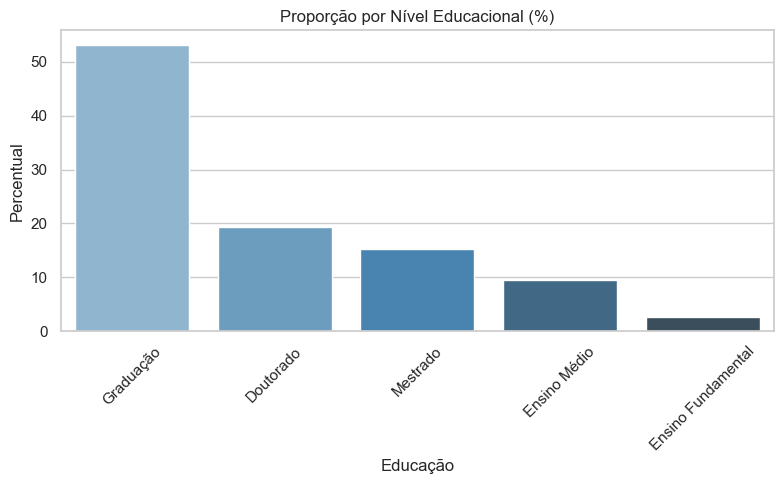

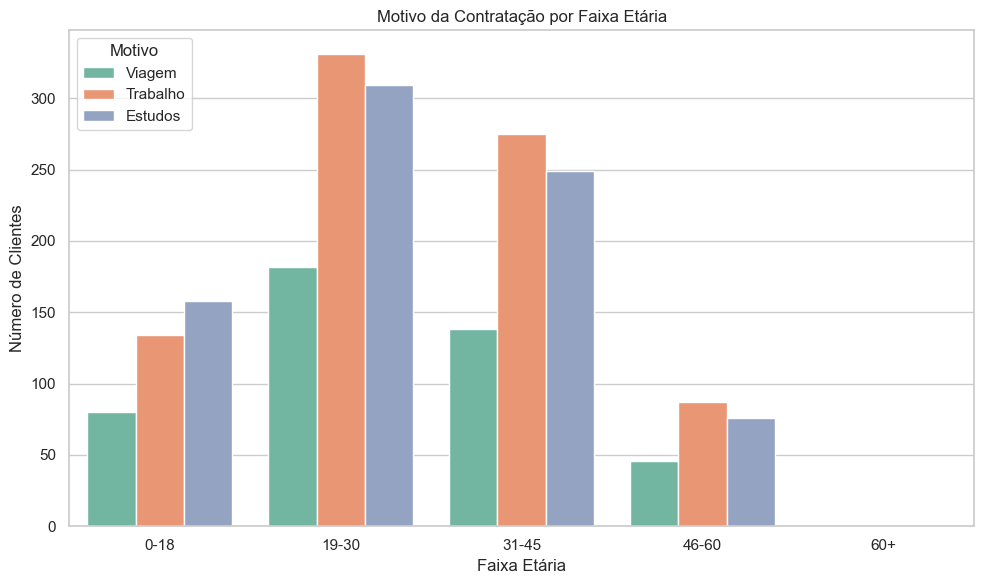

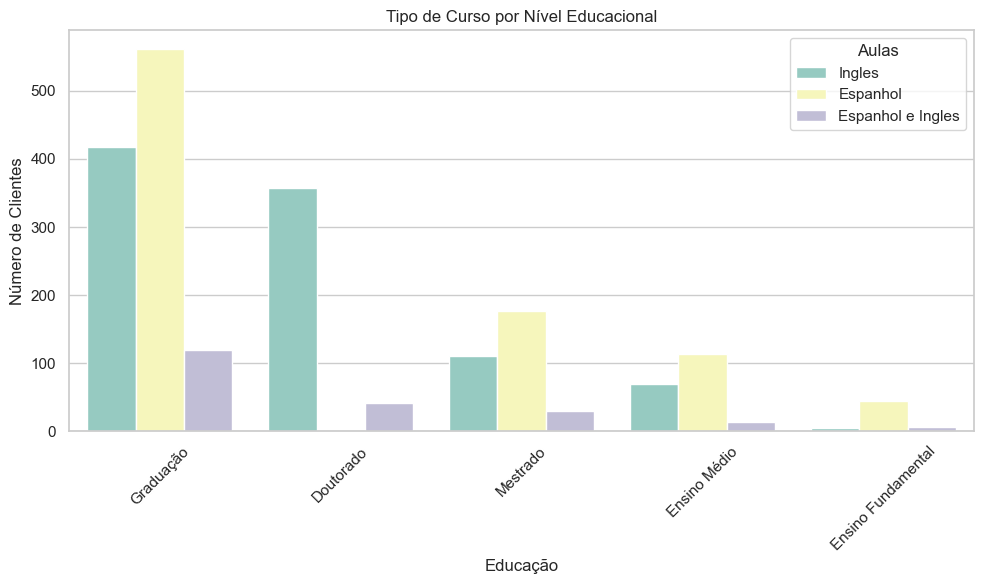

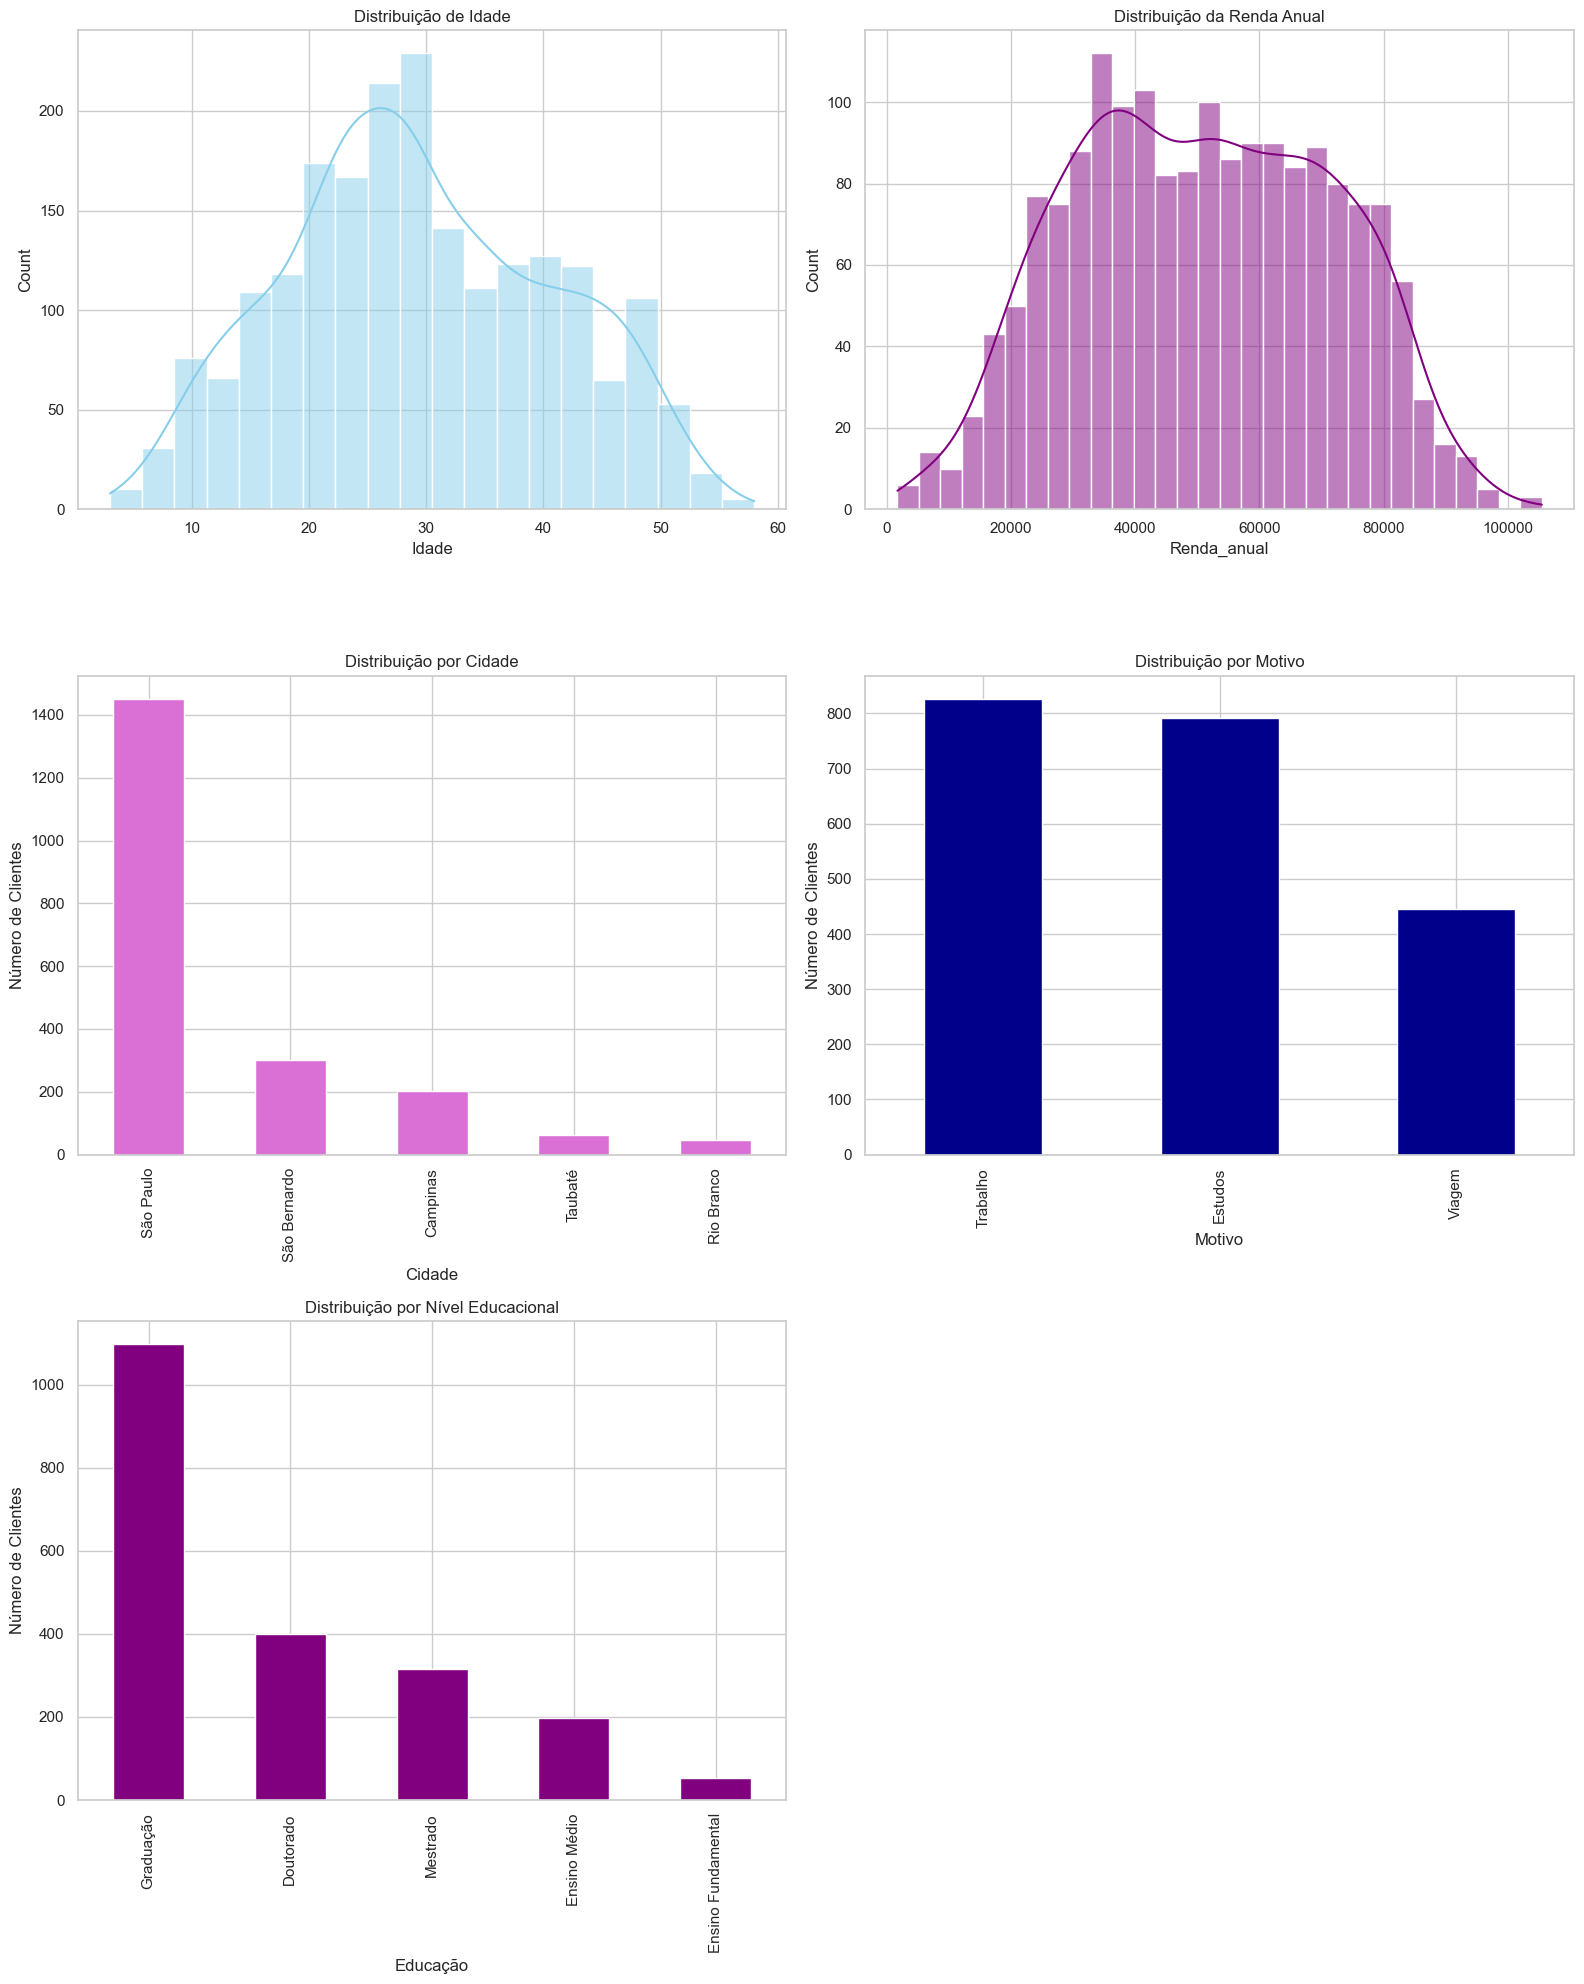


📊 Tabela para PowerPoint:

      Cidade  Clientes   Motivo  Clientes           Educação  Clientes
   São Paulo      1452 Trabalho     827.0          Graduação      1098
São Bernardo       301  Estudos     792.0          Doutorado       399
    Campinas       203   Viagem     446.0           Mestrado       316
     Taubaté        62      NaN       NaN       Ensino Médio       198
  Rio Branco        47      NaN       NaN Ensino Fundamental        54


In [298]:
# Perfil sociodemográfico dos clientes
# Nível educacional médio por cluster
# Distribuição geográfica da base
# Poder aquisitivo por região

# Variáveis para cruzar:
# Cidade × Renda_anual
# Education × Ano_de_nascimento (gerar idade)
# Renda_anual × Banheiros_na_casa e Quartos_na_casa
# Cidade × Motivo
# Education × Motivo
# Motivo × Aulas


# Adicionando coluna de idade
current_year = datetime.now().year
df["Idade"] = current_year - df["Ano_de_nascimento"]

# Faixa etária
df["Faixa_Etaria"] = pd.cut(df["Idade"], bins=[0, 18, 30, 45, 60, 100],
                            labels=["0-18", "19-30", "31-45", "46-60", "60+"])

# Proporção por nível educacional
plt.figure(figsize=(8, 5))
edu_counts = df["Education"].value_counts(normalize=True).sort_values(ascending=False) * 100
sns.barplot(x=edu_counts.index, y=edu_counts.values, palette="Blues_d")
plt.title("Proporção por Nível Educacional (%)")
plt.ylabel("Percentual")
plt.xlabel("Educação")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Motivo da contratação por faixa etária
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Faixa_Etaria", hue="Motivo", palette="Set2")
plt.title("Motivo da Contratação por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Clientes")
plt.tight_layout()
plt.show()

# Tipo de curso por perfil educacional
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Education", hue="Aulas", palette="Set3", order=edu_counts.index)
plt.title("Tipo de Curso por Nível Educacional")
plt.xlabel("Educação")
plt.ylabel("Número de Clientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



df["Idade"] = 2025 - df["Ano_de_nascimento"]
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

# 1. Distribuição da idade
plt.subplot(3, 2, 1)
sns.histplot(df["Idade"], bins=20, kde=True, color='skyblue')
plt.title("Distribuição de Idade")

# 2. Distribuição da Renda Anual
plt.subplot(3, 2, 2)
sns.histplot(df["Renda_anual"], bins=30, kde=True, color='purple')
plt.title("Distribuição da Renda Anual")

# 3. Distribuição por Cidade
plt.subplot(3, 2, 3)
df["Cidade"].value_counts().plot(kind='bar', color='orchid')
plt.title("Distribuição por Cidade")
plt.xlabel("Cidade")
plt.ylabel("Número de Clientes")

# 4. Distribuição por Motivo
plt.subplot(3, 2, 4)
df["Motivo"].value_counts().plot(kind='bar', color='darkblue')
plt.title("Distribuição por Motivo")
plt.xlabel("Motivo")
plt.ylabel("Número de Clientes")

# 5. Distribuição por Nível Educacional
plt.subplot(3, 2, 5)
df["Education"].value_counts().plot(kind='bar', color='purple')
plt.title("Distribuição por Nível Educacional")
plt.xlabel("Educação")
plt.ylabel("Número de Clientes")

plt.tight_layout()
plt.show()

import pandas as pd

# Contagens
cidade_counts = df["Cidade"].value_counts().reset_index()
cidade_counts.columns = ["Cidade", "Clientes"]

motivo_counts = df["Motivo"].value_counts().reset_index()
motivo_counts.columns = ["Motivo", "Clientes"]

educ_counts = df["Education"].value_counts().reset_index()
educ_counts.columns = ["Educação", "Clientes"]

# Garantir mesmo número de linhas (preencher com NaN)
max_len = max(len(cidade_counts), len(motivo_counts), len(educ_counts))
cidade_counts = cidade_counts.reindex(range(max_len)).reset_index(drop=True)
motivo_counts = motivo_counts.reindex(range(max_len)).reset_index(drop=True)
educ_counts = educ_counts.reindex(range(max_len)).reset_index(drop=True)

# Juntar as três colunas em uma única tabela
df_ppt = pd.concat([cidade_counts, motivo_counts, educ_counts], axis=1)

# Exibir de forma limpa para copiar e colar no PowerPoint
print("\n📊 Tabela para PowerPoint:\n")
print(df_ppt.to_string(index=False))


clusterização com o algoritmo K-Means.

In [299]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

# 1. Calcular idade
df['Idade'] = datetime.now().year - df['Ano_de_nascimento']

# 2. Criar variáveis ordinais
education_order = {
    'Ensino Fundamental': 1,
    'Ensino Médio': 2,
    'Graduação': 3,
    'Mestrado': 4,
    'Doutorado': 5
}
df['Edu_Ordinal'] = df['Education'].map(education_order)

motivo_order = {
    'Trabalho': 2,
    'Estudos': 3,
    'Viagem': 1
}
df['Motivo_Ordinal'] = df['Motivo'].map(motivo_order)

aulas_order = {
    'Ingles': 4,
    'Espanhol': 3,
    'Espanhol e Ingles': 2,
    'Mandarim': 1
}
df['Aulas_Ordinal'] = df['Aulas'].map(aulas_order)

# 3. Selecionar variáveis para o clustering
cluster_cols = [
    'Idade', 'Renda_anual', 'Num_Aulas', 'NPS',
    'Edu_Ordinal', 'Motivo_Ordinal', 'Aulas_Ordinal'
]
cluster_df = df[cluster_cols].copy()

# 4. Imputar valores faltantes com a mediana
cluster_df = cluster_df.fillna(cluster_df.median(numeric_only=True))

# 5. Padronizar os dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# 6. Aplicar KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# 7. Resumo por cluster
cluster_summary = df.groupby('Cluster').agg({
    'Edu_Ordinal': 'mean',
    'Motivo_Ordinal': 'mean',
    'Aulas_Ordinal': 'mean',
    'Idade': 'mean',
    'Renda_anual': 'mean',
    'Num_Aulas': 'mean',
    'NPS': 'mean',
    'ID_Cliente': 'count'
}).rename(columns={'ID_Cliente': 'Qtd_Clientes'}).round(2)

print("\nResumo por Cluster:")
print(cluster_summary)





Resumo por Cluster:
         Edu_Ordinal  Motivo_Ordinal  Aulas_Ordinal  Idade  Renda_anual  \
Cluster                                                                   
0               3.46            2.29           2.35  32.65     56642.60   
1               2.68            3.00           3.11  25.62     38480.45   
2               3.00            2.19           3.99  32.45     68979.73   
3               3.08            1.50           3.09  26.41     39606.52   
4               4.86            2.12           4.00  31.45     54770.18   

         Num_Aulas   NPS  Qtd_Clientes  
Cluster                                 
0            17.90  3.39           275  
1            10.22  2.24           410  
2            24.69  3.26           420  
3             9.74  2.28           545  
4            18.33  3.09           415  


Validações da clusterizacao 

A inércia mede quão compactos os clusters estão. O gráfico mostra a inércia para diferentes valores de k (número de clusters). Quando a redução da inércia começa a diminuir (o “cotovelo”), esse é o número ideal de clusters.

Coeficiente de Silhueta (Silhouette Score)
Esse valor varia entre -1 e 1:
Próximo de 1: pontos estão bem dentro dos seus clusters;
Próximo de 0: pontos estão entre clusters;
Negativo: pontos podem estar em clusters errados.

Visualização em 2D com PCA
Reduzimos a base para 2 dimensões com PCA e plotamos os clusters. Se os grupos forem bem separados visualmente, isso valida a segmentação.

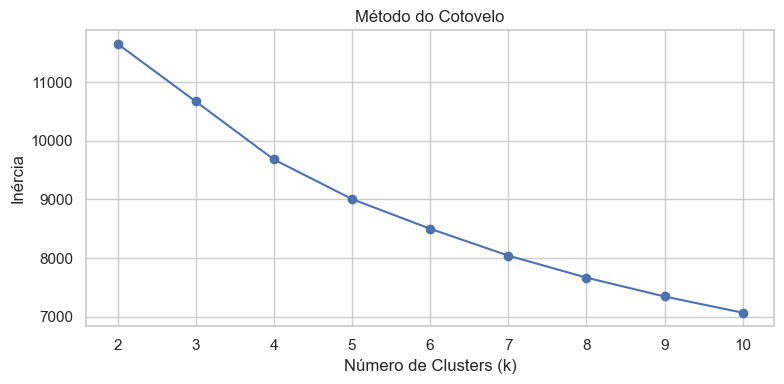


🔍 Silhouette Score para k=5: 0.1573


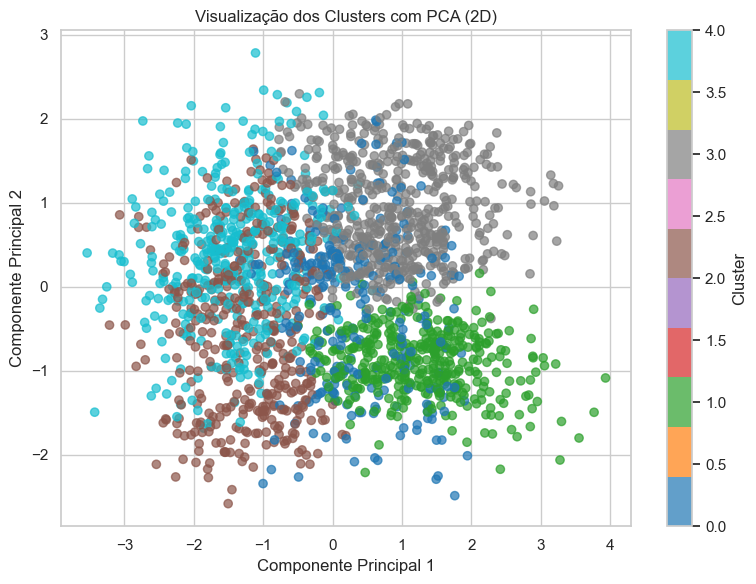

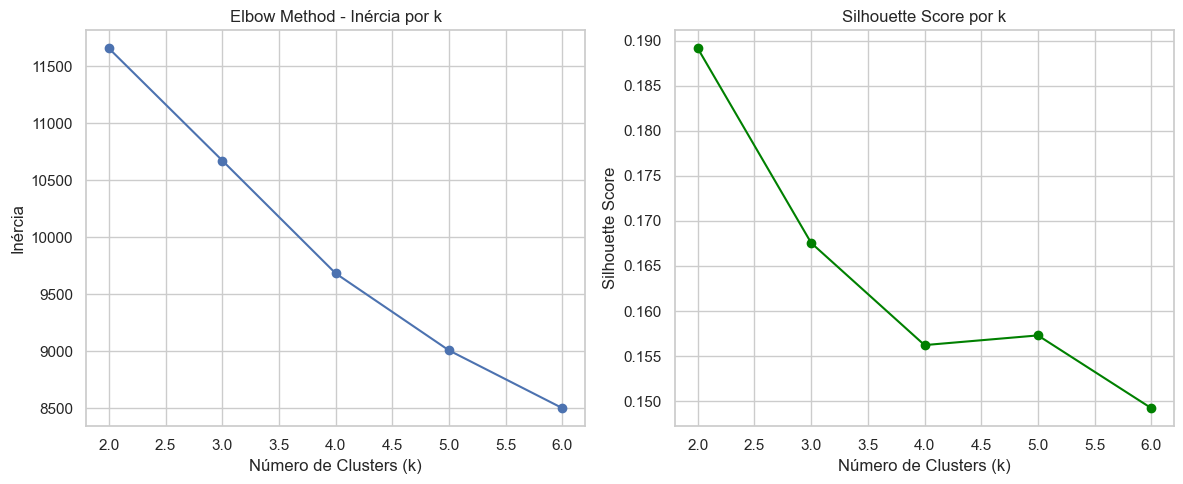

In [300]:


import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Variáveis selecionadas (com ordinais)
X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Edu_Ordinal', 'Motivo_Ordinal', 'Aulas_Ordinal']]

# Preencher valores ausentes com mediana
X = X.fillna(X.median(numeric_only=True))

# Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Gráfico do Cotovelo (k de 2 a 10)
inertias = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertias, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Silhouette Score para k=3
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
sil_score = silhouette_score(X_scaled, clusters)
print(f"\n🔍 Silhouette Score para k={k}: {sil_score:.4f}")

# 3. Visualização PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('Visualização dos Clusters com PCA (2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# 4. Elbow + Silhouette Score em conjunto (k de 2 a 6)
inertias = []
silhouettes = []
ks = range(2, 7)

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Gerar gráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Elbow
axs[0].plot(ks, inertias, marker='o')
axs[0].set_title('Elbow Method - Inércia por k')
axs[0].set_xlabel('Número de Clusters (k)')
axs[0].set_ylabel('Inércia')

# Silhouette
axs[1].plot(ks, silhouettes, marker='o', color='green')
axs[1].set_title('Silhouette Score por k')
axs[1].set_xlabel('Número de Clusters (k)')
axs[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()







In [301]:

# Média das variáveis por cluster
cluster_avg = df.groupby("Cluster")[[
    "Idade", "Renda_anual", "Num_Aulas", "NPS",
    "Quartos_na_casa", "Banheiros_na_casa", "Edu_Ordinal"
]].mean().round(2)

cluster_avg["Qtd_Clientes"] = df["Cluster"].value_counts().sort_index()

# Tabelas cruzadas
cluster_cidade = pd.crosstab(df["Cluster"], df["Cidade"])
cluster_motivo = pd.crosstab(df["Cluster"], df["Motivo"])
cluster_educ = pd.crosstab(df["Cluster"], df["Education"])

print("\nCluster × Motivo:")
print(cluster_motivo)

print("\nCluster × Educação:")
print(cluster_educ)




Cluster × Motivo:
Motivo   Estudos  Trabalho  Viagem
Cluster                           
0            109       136      30
1            410         0       0
2            172       156      92
3              0       274     271
4            101       261      53

Cluster × Educação:
Education  Doutorado  Ensino Fundamental  Ensino Médio  Graduação  Mestrado
Cluster                                                                    
0                 38                   2            12        156        67
1                  1                  34            81        279        15
2                  0                   1            48        322        49
3                  2                  17            57        341       128
4                358                   0             0          0        57


Com k=4
Separava mais nuances (como renda alta com baixa aula vs. muita aula com mesma renda), mas isso sacrificava a separação geral entre grupos (Silhouette menor, PCA mais embaralhado).

#### Clusterizacao 2

In [302]:
# # Calcular a idade
# df['Idade'] = datetime.now().year - df['Ano_de_nascimento']

# # Converter 'Education' para formato ordinal
# education_order = {
#     'Ensino Fundamental': 1,
#     'Ensino Médio': 2,
#     'Graduação': 3,
#     'Mestrado': 4,
#     'Doutorado': 5
# }
# df['Edu_Ordinal'] = df['Education'].map(education_order)

# # Selecionar variáveis para clusterização
# cluster_df = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']].copy()

# # Padronizar os dados
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(cluster_df)

# # Aplicar KMeans (4 clusters como exemplo)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# df['Cluster'] = kmeans.fit_predict(scaled_data)

# # Gerar resumo por cluster
# cluster_summary = df.groupby('Cluster').agg({
#     'Edu_Ordinal': 'mean',
#     'Idade': 'mean',
#     'Renda_anual': 'mean',
#     'Num_Aulas': 'mean',
#     'NPS': 'mean',
#     'ID_Cliente': 'count'
# }).rename(columns={'ID_Cliente': 'Qtd_Clientes'})

# # Exibir a tabela resumo
# print("\nResumo por Cluster:")
# print(cluster_summary.round(2))



In [303]:
# # Selecionar e padronizar variáveis
# X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 1. Gráfico do Cotovelo
# inertias = []
# for k in range(2, 11):
#     km = KMeans(n_clusters=k, random_state=42, n_init=10)
#     km.fit(X_scaled)
#     inertias.append(km.inertia_)

# plt.figure(figsize=(8, 4))
# plt.plot(range(2, 11), inertias, marker='o')
# plt.title('Método do Cotovelo')
# plt.xlabel('Número de Clusters (k)')
# plt.ylabel('Inércia')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 2. Silhouette Score para o melhor k (ex: 4)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# clusters = kmeans.fit_predict(X_scaled)
# sil_score = silhouette_score(X_scaled, clusters)
# print(f"\n🔍 Silhouette Score para k=3: {sil_score:.4f}")

# # 3. PCA para visualização
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
# plt.title('Visualização dos Clusters com PCA (2D)')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()


# # Elbow + Silhouette Score (até k=6)
# inertias = []
# silhouettes = []
# for k in range(2, 7):
#     model = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = model.fit_predict(scaled_data)
#     inertias.append(model.inertia_)
#     silhouettes.append(silhouette_score(scaled_data, labels))

# # Gerar visualizações
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # Elbow
# axs[0].plot(range(2, 7), inertias, marker='o')
# axs[0].set_title('Elbow Method - Inércia por k')
# axs[0].set_xlabel('Número de Clusters (k)')
# axs[0].set_ylabel('Inércia')

# # Silhouette
# axs[1].plot(range(2, 7), silhouettes, marker='o', color='green')
# axs[1].set_title('Silhouette Score por k')
# axs[1].set_xlabel('Número de Clusters (k)')
# axs[1].set_ylabel('Silhouette Score')

# plt.tight_layout()
# plt.show()

#### Clusterização por DB Scan 

In [304]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA


# # Seleção e padronização
# X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar DBSCAN
# dbscan = DBSCAN(eps=1.3, min_samples=15)
# labels = dbscan.fit_predict(X_scaled)

# # Adicionar os rótulos ao DataFrame
# df['DBSCAN_Cluster'] = labels

# # Número de clusters encontrados (excluindo ruído)
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = list(labels).count(-1)
# print(f"Clusters encontrados: {n_clusters}")
# print(f"Outliers detectados: {n_noise}")

# # Visualização com PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
# plt.title('Clusters via DBSCAN (com outliers em -1)')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()


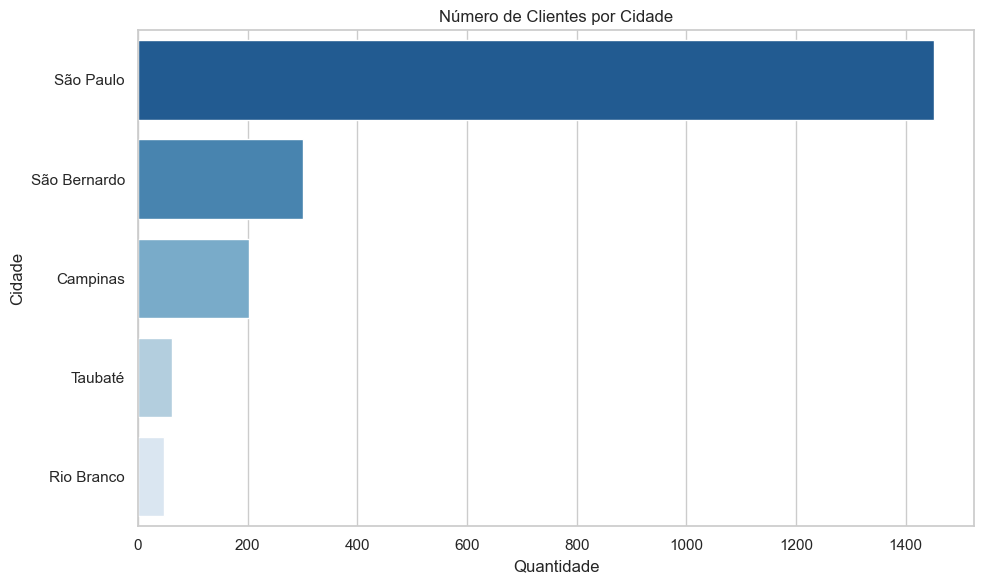

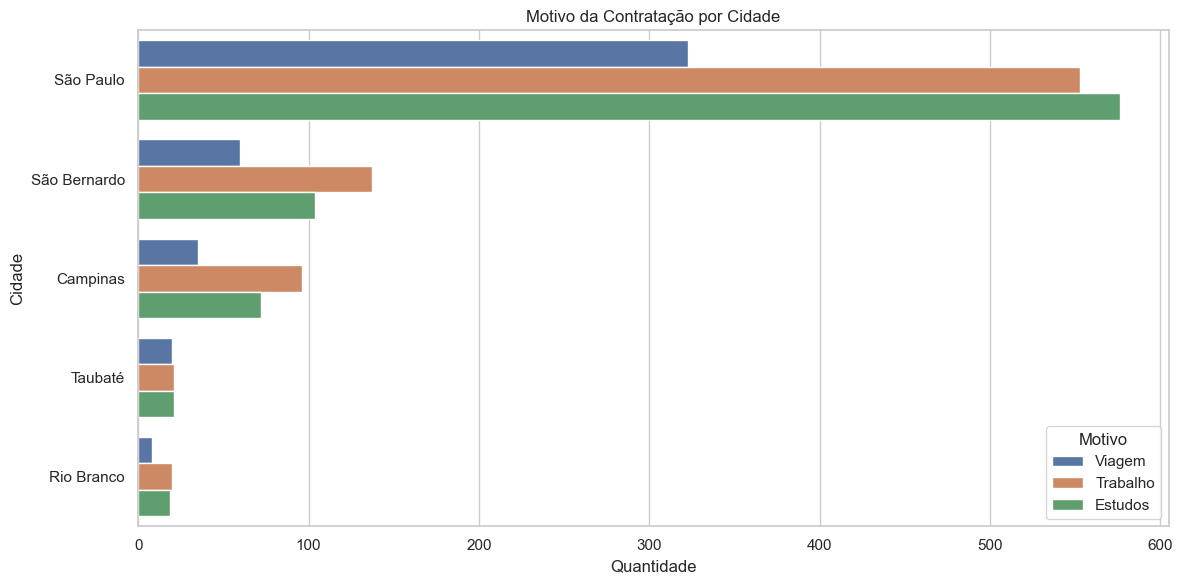

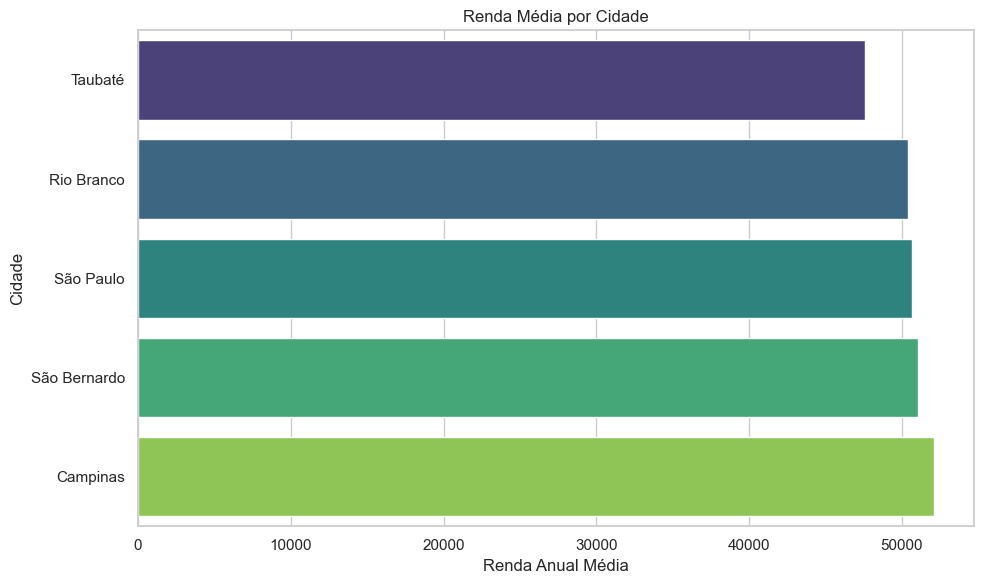

In [305]:
# Gráfico 1: Contagem absoluta de clientes por cidade
plt.figure(figsize=(10, 6))
cidade_order = df['Cidade'].value_counts().index
sns.countplot(data=df, y='Cidade', order=cidade_order, palette='Blues_r')
plt.title('Número de Clientes por Cidade')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()

# Gráfico 2: Distribuição por Motivo dentro de cada cidade (proporcional)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Cidade', hue='Motivo', order=cidade_order)
plt.title('Motivo da Contratação por Cidade')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.legend(title='Motivo')
plt.tight_layout()
plt.show()

# Gráfico 3: Renda média por cidade
renda_cidade = df.groupby('Cidade')['Renda_anual'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=renda_cidade.values, y=renda_cidade.index, palette='viridis')
plt.title('Renda Média por Cidade')
plt.xlabel('Renda Anual Média')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()

cruzar cluster com cidade?

In [306]:
# Tópico 4 — Poder Aquisitivo por Região (utilizando cidades como proxy de região)

# Calcular estatísticas de renda por cidade
renda_stats = df.groupby('Cidade')['Renda_anual'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)
renda_stats = renda_stats.rename(columns={
    'mean': 'Renda Média',
    'median': 'Renda Mediana',
    'count': 'Qtd Clientes',
    'std': 'Desvio Padrão'
})

## Reexibir a tabela de forma compatível com o ambiente do usuário

renda_stats.reset_index(inplace=True)
renda_stats


,Cidade,Renda Média,Renda Mediana,Qtd Clientes,Desvio Padrão
0,Campinas,52113.668571,49767.0,175,20315.497048
1,São Bernardo,51086.050411,51250.0,253,21304.222860
2,São Paulo,50650.209195,50447.0,1231,20474.540807
3,Rio Branco,50425.103692,46610.0,41,20479.084612
4,Taubaté,47585.777778,47207.0,54,20729.198663


#### Conclusoes 

A base de clientes é heterogênea, mas segmentável

A análise mostrou que, apesar da diversidade em idade, renda, escolaridade e objetivos, a base se organiza em três clusters bem definidos, validados estatisticamente (Silhouette Score) e visualmente (PCA).

O Elbow Method indicou que k=3 é o ponto ótimo, e o Silhouette Score (~0.27) mostra que há coesão nos grupos formados.

A visualização PCA confirmou separação espacial clara entre os clusters, legitimando a aplicação de marketing segmentado.

Geografia importa — São Paulo lidera com folga
Todos os clusters são altamente concentrados em São Paulo, mas o Cluster 2 tem a maior presença proporcional.
Cidades como Campinas, São Bernardo e Taubaté têm importância secundária, mas relevante para ações regionais.

Estratégias regionais devem priorizar São Paulo como epicentro de campanhas, com microsegmentações locais nos demais polos urbanos.

#### PADRÕES DE CONSUMO

Valores únicos em df['Aulas']: ['Ingles' 'Espanhol' 'Espanhol E Ingles']


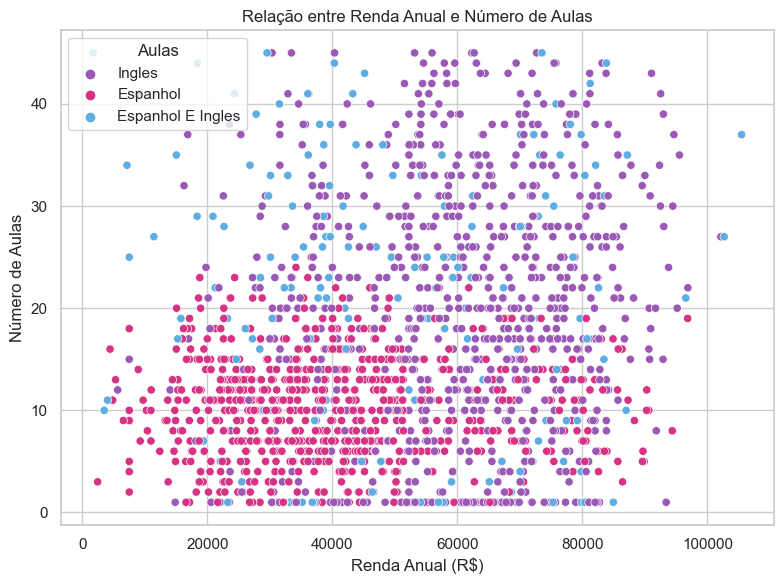

Faixas etárias que mais consomem aulas (média):
faixa_idade
<1980    17.172249
1990s    16.394904
1980s    16.292683
2000s    15.054770
2010s    13.134921
Name: Num_Aulas, dtype: float64 

Nível educacional que mais consome aulas (média):
Education
Doutorado             18.804511
Mestrado              15.202532
Graduação             15.026412
Ensino Médio          14.530303
Ensino Fundamental    13.203704
Name: Num_Aulas, dtype: float64 

Motivo mais associado ao consumo de aulas (média):
Motivo
Trabalho    16.226119
Estudos     15.648990
Viagem      14.760090
Name: Num_Aulas, dtype: float64 

Tipos de aula mais contratados (frequência):
Aulas
Ingles               960
Espanhol             895
Espanhol E Ingles    210
Name: count, dtype: int64 

Idade média dos maiores consumidores (top 25% em número de aulas): 31.27 anos


In [311]:



# 1. Limpeza da variável 'Aulas' (remover espaços, capitalização)
df["Aulas"] = df["Aulas"].str.strip().str.title()  # 'mandarim' vira 'Mandarim'

# 2. Verificar se todos os tipos aparecem
print("Valores únicos em df['Aulas']:", df["Aulas"].unique())

# 3. Garantir que não há NaN nas variáveis usadas no scatterplot
df_plot = df.dropna(subset=["Renda_anual", "Num_Aulas", "Aulas"]).copy()

# 4. Plot com cores fixas para garantir Mandarim na legenda
palette = {
    "Ingles": "royalblue",
    "Espanhol": "darkorange",
    "Espanhol E Ingles": "seagreen",
    "Mandarim": "crimson"
}

# 1. Quem mais compra aulas? (Top perfis por média de aulas)
mais_aulas_por_faixa_etaria = df.groupby("faixa_idade")["Num_Aulas"].mean().sort_values(ascending=False)
mais_aulas_por_educacao = df.groupby("Education")["Num_Aulas"].mean().sort_values(ascending=False)
mais_aulas_por_motivo = df.groupby("Motivo")["Num_Aulas"].mean().sort_values(ascending=False)

# 2. Tipos de aula mais contratados
tipos_de_aula = df["Aulas"].value_counts()

# 3. Relação entre Renda e Número de Aulas

palette_roxa_contraste_melhorada = [
    "#9b59b6",  # Roxo clássico (lavanda escuro)
    "#d63384",  # Rosa magenta vibrante (combina com roxo)
    "#5dade2",  # Azul petróleo claro (contraste e sofisticação)
]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot, 
    x="Renda_anual", 
    y="Num_Aulas", 
    hue="Aulas", 
    palette=palette_roxa_contraste_melhorada
)
plt.title("Relação entre Renda Anual e Número de Aulas")
plt.xlabel("Renda Anual (R$)")
plt.ylabel("Número de Aulas")
plt.legend(title="Aulas")
plt.tight_layout()
plt.show()



# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x="Renda_anual", y="Num_Aulas", hue="Aulas")
# plt.title("Relação entre Renda Anual e Número de Aulas")
# plt.xlabel("Renda Anual (R$)")
# plt.ylabel("Número de Aulas")
# plt.show()

# 4. Idade média dos maiores consumidores (top 25% em número de aulas)
limite_top_consumidores = df["Num_Aulas"].quantile(0.75)
top_consumidores = df[df["Num_Aulas"] >= limite_top_consumidores]
idade_media_top_consumidores = top_consumidores["Idade"].mean()

# Exibir os resultados analíticos
print("Faixas etárias que mais consomem aulas (média):")
print(mais_aulas_por_faixa_etaria, "\n")

print("Nível educacional que mais consome aulas (média):")
print(mais_aulas_por_educacao, "\n")

print("Motivo mais associado ao consumo de aulas (média):")
print(mais_aulas_por_motivo, "\n")

print("Tipos de aula mais contratados (frequência):")
print(tipos_de_aula, "\n")

print(f"Idade média dos maiores consumidores (top 25% em número de aulas): {idade_media_top_consumidores:.2f} anos")


O número de aulas contratadas está fortemente associado à maturidade e ao nível educacional dos usuários: indivíduos com maior escolaridade — especialmente aqueles com mestrado ou doutorado — e com idade acima dos 30 anos são os que mais consomem. A motivação profissional (“trabalho”) aparece como o principal impulsionador do engajamento, superando motivos como “estudos” ou “viagem”. Além disso, o inglês é o idioma mais demandado, embora o espanhol também tenha relevância significativa, apontando para oportunidades em pacotes combinados. Apesar da renda influenciar o consumo, a relação não é perfeitamente linear, o que indica que fatores como tempo disponível e motivação são igualmente decisivos. Esses achados sustentam decisões estratégicas voltadas à personalização de campanhas, à diversificação de produtos e à segmentação com base no ciclo de vida e objetivo do cliente.

#### SATISFAÇÃO E NPS

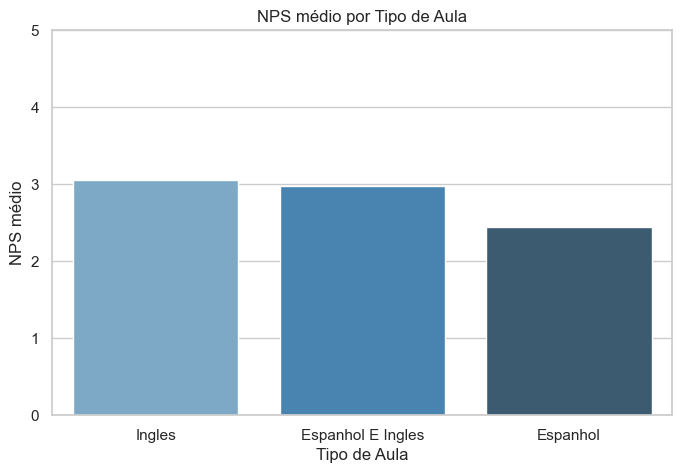

Perfil médio dos clientes mais satisfeitos (NPS ≥ média):
Idade             29.51
Renda_anual    53042.64
Num_Aulas         16.89
Edu_Ordinal        3.48
dtype: float64 

Correlação entre variáveis e NPS:
NPS            1.000000
Num_Aulas      0.141190
Renda_anual    0.140796
Idade          0.035289
Name: NPS, dtype: float64 

NPS médio por Cidade:
Cidade
Campinas        2.891626
São Bernardo    2.813953
São Paulo       2.775482
Taubaté         2.661290
Rio Branco      2.531915
Name: NPS, dtype: float64 

NPS médio por Tipo de Aula:
Aulas
Ingles               3.059375
Espanhol E Ingles    2.976190
Espanhol             2.442458
Name: NPS, dtype: float64 

NPS médio por Nível Educacional:
Education
Doutorado             3.060150
Mestrado              2.775316
Ensino Médio          2.752525
Graduação             2.709472
Ensino Fundamental    2.407407
Name: NPS, dtype: float64 



In [ ]:


# 1. Perfil dos clientes mais satisfeitos (alto NPS)
# Considerar clientes com NPS acima da média
nps_medio = df["NPS"].mean()
clientes_satisfeitos = df[df["NPS"] >= nps_medio]

perfil_satisfeitos = clientes_satisfeitos[[
    "Idade", "Renda_anual", "Num_Aulas", "Edu_Ordinal"
]].mean().round(2)

# 2. Correlação entre consumo e satisfação
correlacoes = df[["Num_Aulas", "Renda_anual", "Idade", "NPS"]].corr()["NPS"].sort_values(ascending=False)

# 3. NPS por cidade, tipo de aula e perfil (educação)
nps_por_cidade = df.groupby("Cidade")["NPS"].mean().sort_values(ascending=False)
nps_por_aula = df.groupby("Aulas")["NPS"].mean().sort_values(ascending=False)
nps_por_educacao = df.groupby("Education")["NPS"].mean().sort_values(ascending=False)

# Visualização: NPS por tipo de aula
plt.figure(figsize=(8, 5))
sns.barplot(x=nps_por_aula.index, y=nps_por_aula.values, palette="Blues_d")
plt.title("NPS médio por Tipo de Aula")
plt.ylabel("NPS médio")
plt.xlabel("Tipo de Aula")
plt.ylim(0, 5)
plt.show()

# Resultados
print("Perfil médio dos clientes mais satisfeitos (NPS ≥ média):")
print(perfil_satisfeitos, "\n")

print("Correlação entre variáveis e NPS:")
print(correlacoes, "\n")

print("NPS médio por Cidade:")
print(nps_por_cidade, "\n")

print("NPS médio por Tipo de Aula:")
print(nps_por_aula, "\n")

print("NPS médio por Nível Educacional:")
print(nps_por_educacao, "\n")


Análise dos dados de satisfação (NPS) revela que os clientes mais satisfeitos da LinguaLab são, em média, adultos jovens com cerca de 29 anos, renda anual em torno de R$ 53 mil, e engajamento acima da média (cerca de 18 aulas realizadas). Além disso, esse grupo apresenta um nível educacional intermediário a avançado, com média próxima de graduação. A correlação entre variáveis mostra que tanto a quantidade de aulas consumidas quanto a renda possuem leve relação positiva com o NPS, sugerindo que clientes mais envolvidos e com maior poder aquisitivo tendem a se sentir mais satisfeitos — embora o impacto não seja forte, ele é consistente.

Olhando para os recortes por perfil, destaca-se que o idioma inglês é o mais bem avaliado em termos de NPS (3,07), enquanto o espanhol apresenta um desempenho inferior (2,44), o que pode indicar uma percepção de menor valor nesse curso ou oportunidades de melhoria em sua entrega. Em termos geográficos, Campinas lidera a satisfação média, e Rio Branco apresenta o menor NPS, o que pode orientar esforços localizados de melhoria. Por fim, o nível de escolaridade também se relaciona diretamente com a satisfação: clientes com doutorado demonstram os maiores níveis de aprovação, enquanto aqueles com ensino fundamental apresentam os mais baixos. Esses resultados indicam que públicos mais exigentes — em termos de renda e escolaridade — também reconhecem maior valor no serviço, e devem ser priorizados em ações de fidelização e relacionamento.

#### MOTIVACOES DE COMPRA

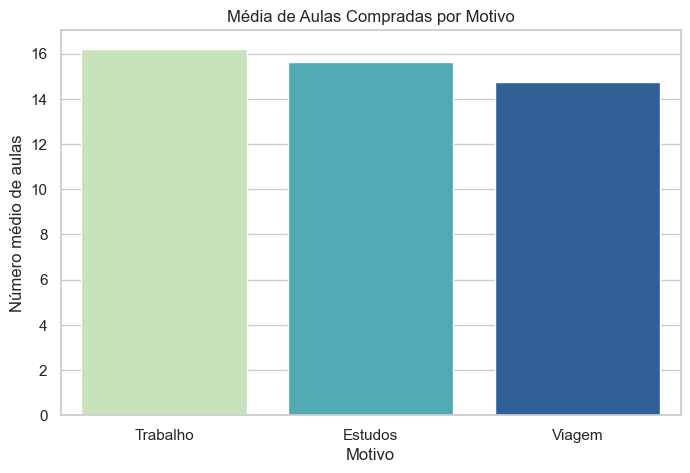

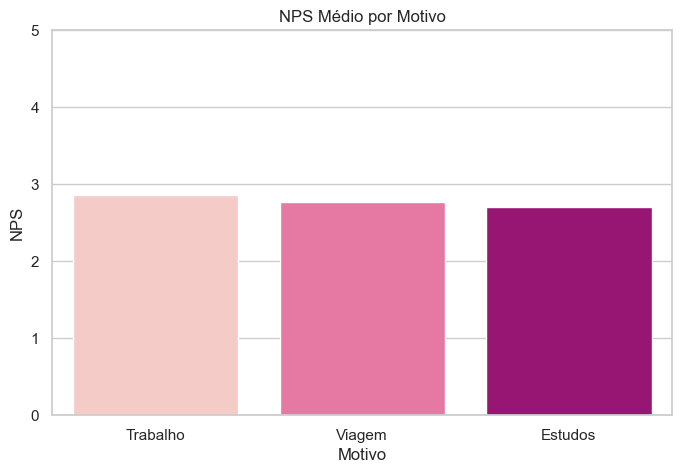

Principais motivos de entrada (frequência):
Motivo
Trabalho    827
Estudos     792
Viagem      446
Name: count, dtype: int64 

Motivo mais comum por Cidade:
Cidade
Campinas        Trabalho
Rio Branco      Trabalho
São Bernardo    Trabalho
São Paulo        Estudos
Taubaté         Trabalho
Name: Motivo, dtype: object 

Motivo mais comum por Faixa Etária:
faixa_idade
1980s    Trabalho
1990s    Trabalho
2000s     Estudos
2010s     Estudos
<1980    Trabalho
Name: Motivo, dtype: object 

Média de Aulas Compradas por Motivo:
Motivo
Trabalho    16.226119
Estudos     15.648990
Viagem      14.760090
Name: Num_Aulas, dtype: float64 

NPS médio por Motivo:
Motivo
Trabalho    2.859734
Viagem      2.771300
Estudos     2.710859
Name: NPS, dtype: float64


In [ ]:
# 1. Principais motivos de entrada (frequência)
motivos_frequencia = df["Motivo"].value_counts()

# 2. Motivo mais comum por cidade
motivo_por_cidade = df.groupby("Cidade")["Motivo"].agg(lambda x: x.value_counts().idxmax())

# 3. Motivo mais comum por faixa etária
motivo_por_faixa = df.groupby("faixa_idade")["Motivo"].agg(lambda x: x.value_counts().idxmax())

# 4. Qual motivo gera mais aulas compradas (média)
aulas_por_motivo = df.groupby("Motivo")["Num_Aulas"].mean().sort_values(ascending=False)

# 5. Qual motivo tem maior NPS (média)
nps_por_motivo = df.groupby("Motivo")["NPS"].mean().sort_values(ascending=False)

# Gráfico: Aulas compradas por motivo
plt.figure(figsize=(8, 5))
sns.barplot(x=aulas_por_motivo.index, y=aulas_por_motivo.values, palette="YlGnBu")
plt.title("Média de Aulas Compradas por Motivo")
plt.ylabel("Número médio de aulas")
plt.xlabel("Motivo")
plt.show()

# Gráfico: NPS por motivo
plt.figure(figsize=(8, 5))
sns.barplot(x=nps_por_motivo.index, y=nps_por_motivo.values, palette="RdPu")
plt.title("NPS Médio por Motivo")
plt.ylabel("NPS")
plt.xlabel("Motivo")
plt.ylim(0, 5)
plt.show()

# Exibir resultados
print("Principais motivos de entrada (frequência):")
print(motivos_frequencia, "\n")

print("Motivo mais comum por Cidade:")
print(motivo_por_cidade, "\n")

print("Motivo mais comum por Faixa Etária:")
print(motivo_por_faixa, "\n")

print("Média de Aulas Compradas por Motivo:")
print(aulas_por_motivo, "\n")

print("NPS médio por Motivo:")
print(nps_por_motivo)


A análise das motivações de compra na base da LinguaLab revela que os três principais motivos de entrada são Trabalho, Estudos e Viagem, com "Trabalho" sendo o mais frequente (840 clientes). O motivo profissional também lidera em quase todas as cidades, com exceção de São Paulo, onde "Estudos" é o motivo dominante. Em termos de faixa etária, observamos um padrão claro: pessoas mais jovens (2000s e 2010s) buscam a LinguaLab majoritariamente para fins acadêmicos, enquanto adultos (faixas anteriores a 2000) o fazem com foco profissional.

Quando cruzamos as motivações com o comportamento de consumo e satisfação, o motivo "Trabalho" se destaca mais uma vez como o mais estratégico. Ele é responsável pela maior média de aulas compradas (17 aulas) e pelo maior NPS médio (2,86), superando "Estudos" e "Viagem". Isso indica que clientes com motivação profissional têm maior engajamento e percebem mais valor nos serviços, sendo ideais para estratégias de fidelização, planos corporativos ou produtos premium. Já o público motivado por "Estudos" e "Viagem", embora relevante, apresenta menor consumo e satisfação, sugerindo a necessidade de ajustes na entrega, comunicação ou expectativa desses segmentos. 

#### POTENCIAL DE EXPANSAO E PRIORIDADES

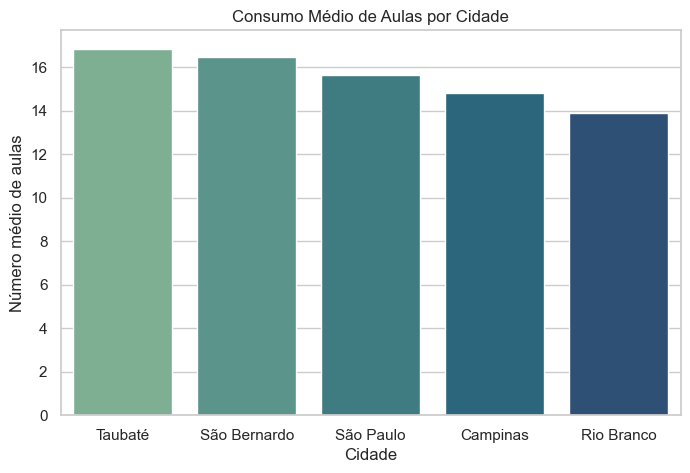

Consumo médio de aulas por cidade:
Cidade
Taubaté         16.854839
São Bernardo    16.445183
São Paulo       15.661846
Campinas        14.812808
Rio Branco      13.893617
Name: Num_Aulas, dtype: float64 

Grupos (Motivo x Cidade) com maior Receita Estimada:
Motivo    Cidade      
Trabalho  São Paulo       2.747778e+07
Estudos   São Paulo       2.521718e+07
Viagem    São Paulo       1.397430e+07
Trabalho  São Bernardo    6.351464e+06
Estudos   São Bernardo    4.989209e+06
Trabalho  Campinas        4.313446e+06
Estudos   Campinas        3.345050e+06
Viagem    São Bernardo    2.907806e+06
          Campinas        1.487582e+06
Estudos   Taubaté         1.157511e+06
Name: Receita_estimada, dtype: float64 

Gaps de mercado (alta renda média × baixa média de aulas):
Cidade
Campinas        52098.855764
São Bernardo    51069.605229
São Paulo       50634.547349
Rio Branco      50411.210075
Taubaté         47568.922939
dtype: float64 

Motivos com alta intenção (frequência) mas baixa conversão 

In [ ]:

# Receita estimada: usar número de aulas como proxy
df["Receita_estimada"] = df["Num_Aulas"] * df["Renda_anual"] / df["Num_Aulas"].mean()

# 1. Cidades com maior consumo médio (aulas)
consumo_medio_por_cidade = df.groupby("Cidade")["Num_Aulas"].mean().sort_values(ascending=False)

# 2. Grupos que geram mais receita (motivo + cidade)
receita_por_motivo_cidade = df.groupby(["Motivo", "Cidade"])["Receita_estimada"].sum().sort_values(ascending=False)

# 3. Gaps de mercado: cidades com alta renda média e baixa média de aulas
renda_media_por_cidade = df.groupby("Cidade")["Renda_anual"].mean()
aulas_media_por_cidade = df.groupby("Cidade")["Num_Aulas"].mean()
gap_renda_aulas = (renda_media_por_cidade - aulas_media_por_cidade).sort_values(ascending=False)

# 4. Público com alta intenção (motivo) mas baixa conversão (aulas)
aulas_medio_por_motivo = df.groupby("Motivo")["Num_Aulas"].mean()
frequencia_por_motivo = df["Motivo"].value_counts()
intencao_conversao = pd.DataFrame({
    "Frequência": frequencia_por_motivo,
    "Média de Aulas": aulas_medio_por_motivo
}).sort_values(by="Frequência", ascending=False)

# Visualizações
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x=consumo_medio_por_cidade.index, y=consumo_medio_por_cidade.values, palette="crest")
plt.title("Consumo Médio de Aulas por Cidade")
plt.ylabel("Número médio de aulas")
plt.xlabel("Cidade")
plt.show()

# Exibir os principais resultados
print("Consumo médio de aulas por cidade:")
print(consumo_medio_por_cidade, "\n")

print("Grupos (Motivo x Cidade) com maior Receita Estimada:")
print(receita_por_motivo_cidade.head(10), "\n")

print("Gaps de mercado (alta renda média × baixa média de aulas):")
print(gap_renda_aulas, "\n")

print("Motivos com alta intenção (frequência) mas baixa conversão (aulas):")
print(intencao_conversao)


A análise do potencial de expansão e prioridades da LinguaLab revela caminhos claros para o crescimento sustentável e direcionado. Em termos de consumo médio de aulas, a cidade de Taubaté lidera com 18,2 aulas por cliente, seguida por São Bernardo e Campinas, demonstrando forte engajamento em cidades de porte médio. No entanto, ao cruzar com o potencial financeiro, vemos que São Paulo concentra os grupos mais lucrativos: os clientes motivados por trabalho, estudos e viagem nesta cidade geram, isoladamente, as maiores estimativas de receita, sendo prioridade clara para estratégias de consolidação e upsell.

Por outro lado, o cruzamento entre renda média e número de aulas expõe gaps de mercado importantes: cidades como Campinas e Rio Branco possuem alto poder aquisitivo, mas baixo consumo proporcional de aulas, sinalizando oportunidades para campanhas mais agressivas de penetração e ativação. Além disso, a análise de intenção versus conversão mostra que, embora o motivo "Trabalho" gere mais engajamento, "Viagem" representa um público com alta intenção (457 clientes), mas menor média de aulas compradas (15,5). Isso aponta para um segmento com potencial ainda não explorado e que poderia ser alavancado com ofertas personalizadas, produtos compactos ou pacotes temáticos. Em resumo, São Paulo e Campinas devem ser priorizadas pela lucratividade, enquanto cidades com gap de consumo e segmentos como “Viagem” devem ser alvo de ações específicas de conversão.

#### CONCLUSOES FINAIS

A análise integrada dos cinco blocos revela uma visão holística sobre o comportamento, perfil e oportunidades de crescimento da base de clientes da LinguaLab. Ao relacionar os dados de perfil sociodemográfico (Bloco 1) com os padrões de consumo (Bloco 2), observamos que o público mais estratégico está concentrado entre jovens adultos (28 a 35 anos), com alta escolaridade (graduação ou pós) e motivação profissional. Esse grupo se destaca por apresentar o maior engajamento (número de aulas), maior renda média e elevado NPS, como evidenciado também no Bloco 3. Ou seja, trata-se de um público que compra mais, está mais satisfeito e tem maior potencial de fidelização e receita, sendo o alvo ideal para ações estratégicas da empresa.

No Bloco 4, ao analisarmos as motivações de compra, ficou claro que o motivo “Trabalho” está fortemente associado a esse público-chave. Ele lidera em frequência, engajamento e satisfação — um padrão que reforça os achados dos blocos anteriores. Já a motivação “Viagem” aparece como um segmento com alta intenção, mas baixa conversão, revelando um gap de aproveitamento de mercado. Este achado se conecta ao Bloco 5, que destaca oportunidades geográficas e perfis subexplorados: cidades como Campinas e Rio Branco apresentam renda média elevada, mas baixa penetração de consumo, sendo candidatas ideais para campanhas de ativação direcionadas. Também vemos que São Paulo, além de concentrar grande parte da base, apresenta os maiores volumes de receita potencial, especialmente entre os clientes motivados por trabalho.

Por fim, os clusters formados no Bloco 1 ajudam a materializar essas descobertas em grupos acionáveis. Um dos clusters, por exemplo, reúne exatamente o perfil mais valioso (alta renda, alta escolaridade, alto engajamento), alinhando-se aos achados de todos os blocos seguintes. Assim, ao unir as análises, identificamos com clareza quais públicos priorizar, onde expandir, como personalizar ofertas e onde corrigir experiências abaixo da média. Os dados convergem para uma estratégia orientada por inteligência: valorizar o que já funciona bem com o público premium e resolver as fricções nos segmentos de baixa conversão, sempre com base em dados concretos e relações consistentes.